In [110]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from joblib import dump, load
import pandas as pd 
import numpy as np
import datetime

In [111]:
# MY CRISP ROUTINE

# 1 - BUSINESS UNDERSTANDING AND DATA UNDERSTANDING
"""

Entradas => ['rai',	'data',	'naturezas',	'bairro_cidade',	'recurso',	'tr',	'obm_escala',	'obm_afeto',	'qualificacao',	'sexo']

Tipos de dados das entradas = {
  'rai' : 'int',
  'data': 'timestamp',
  'naturezas' : 'str',
  'bairro_cidade' : 'str',
  'recurso' : 'str',
  'tr': 'datetime.time',
  'obm_escala': 'str',
  'obm_afeto': 'str',
  'qualificacao': 'str',
  'sexo': 'str'
}

A saída é dada por uma rede neural multiclasse que irá classificar as entradas em uma das categorias abaixo:

Saída => ["tempo_resposta"] => ["Muito rápido", "Rápido", "Médio", "Longo", "Muito longo", "Extremamente longo"]

OBS: a saída mais interessante para o negócio é o "recurso", entretanto o algoritmo será realizado em outro momento.
Isso devido ao fato dos recursos formarem muitas categorias.

"""
# 2 - DATA PREPARATION
"""
Entradas => ['rai',	'data',	'naturezas',	'bairro_cidade',	'recurso',	'tr',	'obm_escala',	'obm_afeto',	'qualificacao',	'sexo']
Entradas removidas => ['rai', 'obm_afeto', 'qualificacao']
Entradas convertidas em outros dados:
  - ['data'] => ['dia', 'periodo']
  - ['tr'] => ['tempo_resposta']
"""

"\nEntradas => ['rai',\t'data',\t'naturezas',\t'bairro_cidade',\t'recurso',\t'tr',\t'obm_escala',\t'obm_afeto',\t'qualificacao',\t'sexo']\nEntradas removidas => ['rai', 'obm_afeto', 'qualificacao']\nEntradas convertidas em outros dados:\n  - ['data'] => ['dia', 'periodo']\n  - ['tr'] => ['tempo_resposta']\n"

In [112]:
# DATA PRE-PREPARATION
file_path = '../../../dataset/occurrences.xlsx'

df = pd.read_excel(file_path)
df = df.drop(["rai", "obm_afeto", "qualificacao"], axis=1).loc[0:200000,:]

#REMOVING NULL VALUES
df.loc[pd.isnull(df["data"])]
df.loc[pd.isnull(df["naturezas"])]
df.loc[pd.isnull(df["bairro_cidade"])]
df.loc[pd.isnull(df["tr"])]
df.loc[pd.isnull(df["obm_escala"])]
df.loc[pd.isnull(df["sexo"])]

df = df.loc[df["bairro_cidade"] != "(null)"]
df = df.loc[df["recurso"] != "(null)"]
df = df.loc[df["tr"] != "(null)"]
df = df.loc[df["obm_escala"] != "(null)"]
df = df.loc[df["sexo"] != "(null)"]
df = df.loc[df["sexo"] != "NÃO-INFORMADO"]

#TRANSFORMING "data" COLUMN INTO NEW COLUMNS "dia" e "periodo". ALSO TRANSFORMING "tr" COLUMN INTO "tempo_resposta" COLUMN

def day_name(timestamp):
    weekdays = ('Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo')
    return weekdays[timestamp.weekday()]

def period_of_day(timestamp):
    period = ("Madrugada", "Matutino", "Vespertino", "Noturno")
    # Madrugada 00:00 às 05:59
    # Matutino 06:00 às 11:59
    # Vespertino 12:00 às 17:59
    # Noturno 18:00 às 23:59
    if 0 <= timestamp.hour < 6:
        return period[0]
    elif 6 <= timestamp.hour < 12:
        return period[1]
    elif 12 <= timestamp.hour < 18:
        return period[2]
    elif 18 <= timestamp.hour < 24:
        return period[3]



def response_time(response_time):
    # Muito rápido 0 a 10 minutos
    # Rápido 10 a 15 minutos
    # Médio 15 a 20 minutos
    # Longo 20 a 30 minutos
    # Muito longo 30 a 45 minutos
    # Extremamente longo > 45 minutos

    response_time_metric = ("Muito rápido", "Rápido", "Médio", "Longo", "Muito longo", "Extremamente longo")

    if type(response_time) is datetime.time:

        total_time_in_minutes = response_time.hour*60 + response_time.minute + response_time.second/60

        if 0 <= total_time_in_minutes <= 10:
            return response_time_metric[0]
        elif 10 < total_time_in_minutes <= 15:
            return response_time_metric[1]
        elif 15 < total_time_in_minutes <= 20:
            return response_time_metric[2]
        elif 20 <  total_time_in_minutes <= 30:
            return response_time_metric[3]
        elif 30 < total_time_in_minutes <= 45:
            return response_time_metric[4]
        elif total_time_in_minutes > 45:
            return response_time_metric[5]
        
#Lembrar de remover os valores que não são datetime.time do df["tr"]
df.loc[:, "dia"] = df["data"].apply(day_name)
df.loc[:, "periodo"] = df["data"].apply(period_of_day)
df.loc[:, "tempo_resposta"] = df["tr"].apply(response_time)

#REMOVING "DATA" AND "TR" COLUMNS

df = df.drop(["data", "tr"], axis=1)

#REMOVING NONE VALUES
df = df.dropna()
df = df.mask(df.eq('None')).dropna()
df = df.astype(str)
df.head()

/home/higoreller/miniconda3/envs/condaenv/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Cell F221384 is marked as a date but the serial value -736954.9663425926 is outside the limits for dates. The cell will be treated as an error.
  for idx, row in parser.parse():


,naturezas,bairro_cidade,recurso,obm_escala,sexo,dia,periodo,tempo_resposta
5,RESGATE (3)->EMERGÊNCIA CLÍNICA (304)->ACIDENT...,ZONA RURAL - CATALÃO,UR-181,10º BBM - CATALÃO,MASCULINO,Domingo,Madrugada,Muito rápido
11,RESGATE (3)->INTOXICAÇÃO EXÓGENA (306)->ALCOOL...,VILA NOSSA SENHORA DO CARMO - MORRINHOS,UR-187,12ª CIBM - MORRINHOS,MASCULINO,Domingo,Madrugada,Longo
12,RESGATE (3)->AGRESSÃO (303)->FÍSICA (30301),RESIDENCIAL LAURENTINO MARTINS - GOIANÉSIA,UR-149,18º BBM - GOIANÉSIA,MASCULINO,Domingo,Madrugada,Extremamente longo
13,RESGATE (3)->INTOXICAÇÃO EXÓGENA (306)->ALCOOL...,JARDIM FLORESTA - MINEIROS,UR-172,CIBM DE MINEIROS - INATIVA,MASCULINO,Domingo,Madrugada,Muito longo
15,RESGATE (3)->EMERGÊNCIA CLÍNICA (304)->OUTRO /...,JARDIM SANTO ANTÔNIO - QUIRINÓPOLIS,UR-179,15ª CIBM - QUIRINÓPOLIS,FEMININO,Domingo,Madrugada,Extremamente longo


In [113]:
#COOK PARAMETERS
class_col = 'tempo_resposta'
my_metric = 'accuracy'
random_seed = 33
n_k_folds = 3
my_epochs = 100
hidden_activation = 'relu'
hidden_neurons = 28
my_optimizer = 'adam'
my_loss = 'categorical_crossentropy'

In [114]:
def prepareY(df):
    
    # EXTRACT Y AND DROP FROM DATAFRAME
    Y = df[class_col]

    # ENCODE CLASS VALUES AS INTEGERS
    yencoder = LabelEncoder()
    yencoder.fit(Y)
    return yencoder.transform(Y)

y = prepareY(df)
df = df.drop([class_col], axis=1)
pd.DataFrame(y).head()

,0
0,3
1,1
2,0
3,2
4,0


In [115]:
numerical_ix = df.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df.select_dtypes(include=['object', 'bool']).columns

In [116]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

column_trans = ColumnTransformer(
     [('cat', OrdinalEncoder(),categorical_ix),
      ('num', MinMaxScaler(feature_range=(-1, 1)), numerical_ix)],
     remainder='drop')

column_trans.fit(df)
X = column_trans.transform(df)
pd.DataFrame(X).head()

,0,1,2,3,4,5,6
0,206.0,3601.0,323.0,1.0,1.0,0.0,0.0
1,223.0,3348.0,329.0,4.0,1.0,0.0,0.0
2,199.0,2023.0,293.0,17.0,1.0,0.0,0.0
3,223.0,988.0,314.0,44.0,1.0,0.0,0.0
4,215.0,1185.0,321.0,10.0,0.0,0.0,0.0


In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
yhot = np_utils.to_categorical(y)
yhot_train = np_utils.to_categorical(y_train)
yhot_test = np_utils.to_categorical(y_test)

In [118]:
#DEFINE MODEL
def baseline_model():
	# CREATE MODEL
	model = Sequential()
	# DEFINING HIDDEN LAYERS AND NEURONS
	model.add(Dense(28, input_dim=7, activation=hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	
	# DEFINING SOFTMAX FOR MULTI-CLASS CLASSIFICATION
	model.add(Dense(6, activation='softmax'))
	# COMPILE MODEL
	model.compile(loss=my_loss, optimizer=my_optimizer, metrics=my_metric)
	return model

# MODEL = BASELINE_MODEL()
cmodel = KerasClassifier(build_fn=baseline_model, epochs=my_epochs, batch_size=100, verbose=1)

/tmp/ipykernel_477/1822003026.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cmodel = KerasClassifier(build_fn=baseline_model, epochs=my_epochs, batch_size=100, verbose=1)


In [119]:
#SETTING THE NUMBER OF FOLDS
kfold = KFold(n_splits=3, shuffle=True)

In [120]:
result = cross_val_score(cmodel, X, yhot, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))

Epoch 1/100
680/680 [==============================] - 4s 5ms/step - loss: 2.1951 - accuracy: 0.3268
Epoch 2/100
680/680 [==============================] - 3s 5ms/step - loss: 1.6814 - accuracy: 0.3407
Epoch 3/100
680/680 [==============================] - 2s 3ms/step - loss: 1.6764 - accuracy: 0.3424
Epoch 4/100
680/680 [==============================] - 2s 3ms/step - loss: 1.6719 - accuracy: 0.3426
Epoch 5/100
680/680 [==============================] - 2s 3ms/step - loss: 1.6703 - accuracy: 0.3431
Epoch 6/100
680/680 [==============================] - 2s 3ms/step - loss: 1.6674 - accuracy: 0.3433
Epoch 7/100
680/680 [==============================] - 2s 3ms/step - loss: 1.6656 - accuracy: 0.3436
Epoch 8/100
680/680 [==============================] - 2s 4ms/step - loss: 1.6642 - accuracy: 0.3432
Epoch 9/100
680/680 [==============================] - 4s 5ms/step - loss: 1.6617 - accuracy: 0.3439
Epoch 10/100
680/680 [==============================] - 2s 4ms/step - loss: 1.6638 - accura

In [121]:
model = baseline_model()
model.compile(loss=my_loss, optimizer=my_optimizer, metrics=my_metric)

history = model.fit(X_train, yhot_train, validation_split=0.33,
                    epochs=my_epochs, batch_size=100, verbose=0)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


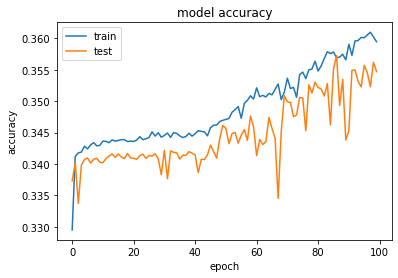

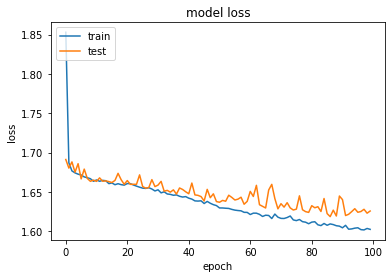

In [122]:
import matplotlib.pyplot as plt
# LIST ALL DATA IN HISTORY
print(history.history.keys())
# SUMMARIZE HISTORY FOR ACCURACY
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# SUMMARIZE HISTORY FOR LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [123]:
# EVALUATE THE KERAS MODEL
_, accuracy = model.evaluate(X_test, yhot_test)
print('Accuracy from evaluate: %.2f' % (accuracy*100))

637/637 [==============================] - 3s 4ms/step - loss: 1.6207 - accuracy: 0.3541
Accuracy from evaluate: 35.41


In [124]:
# VERIFYING THE PREDICTION ACCURACY
predict_x = model.predict(X_test)
pred = np.argmax(predict_x, axis=1)
print(f'Prediction Accuracy: {(pred == y_test).mean() * 100:f}')

Prediction Accuracy: 35.408999
